---
title: "Data exploration: Delta Sv distribution, by scattering layer"
subtitle: "A simple example with horizontal and well defined layers"
author: "Gaspard Ringuenet"
---

We are interested in the partioning of the ESUs' distribution in the $\Delta S_v$ space when grouping by fine-scale sound scattering layers (SSL; could be even called FSSL to distinguish from the objects usually refered to with the term SSL). Our final goal is to achieve unsupervised multifrequency brod ecosystem acoustic target classification at the ESU level. In other word, we want to produce a pixel-wise segmentation of the echogram, representing the distribution of various acoustic communities.

Our hypothesis is $S_v$ structures (FSSLs) provide interesting starting points to identify groups of ESUs representing similar backscattering organisms communities. 

Since extracting the FSSLs from echointegrated acoustic data is not a straightforward task, we would like to assess the relevance of this task for our goal using a *simplified echogram*, in which identifying FSSLs is easy.

To do so, we chose to use a very short echogram part (~30 min, 285 ESDUs) from a clean sequence of the AMAZOMIX survey (LEG 1).

![Screenshot of the selected echogram part in Matecho.](matecho_screenshot.png)

Let's import the netCDF file for the survey and select the part we're interested in.

In [23]:
# Imports
from PIL import Image
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

# Local imports
from src.data.io import load_survey_ds
from src.visualization.visualize_echograms import plot_sv_rgb
from src.exploration.processing import ds_to_sv, filter_depth, get_ch_list, compute_differences, flatten_valid, sample_safe

# Hyperparameters
EI = "amazomix_3pings1m"        # which survey to use as input (see src.exploration.data_config.py)
SV_THRESHOLD = -120             # threshold for min Sv (accross channels), in dB. ESUs with one channel below threshold are removed from analyses
FORCE_PLOT = True

In [24]:
# Import whole survey file
ds = load_survey_ds(survey=EI)

# Extract the `Sv` variable as `xarray.DataArray` and apply a threshold
sv = ds_to_sv(ds, sv_threshold=SV_THRESHOLD)

In [25]:
# Adjust the echogram time frame
frame = 100
start_index = 348984              # time index as displayed in Matecho
end_index = start_index + frame   # added frame length

# Create simplistic layer mask
borders = [40,
           192,
           241,
           252,
           283,
           298,
           339,
           439,
           499] # FSSL borders identified visually on echogram

depth = sv["depth"]
time = sv["time"]

assert np.all(np.diff(depth.values) > 0), "Depth coordinate must be ascending for np.digitize"
borders_full = np.concatenate([[float(depth[0])], borders, [float(depth[-1])]]) # Build full borders (include min and max of depth)

layer_idx = np.digitize(depth, borders_full) - 1  # subtract 1 for 0-based layer indices

layer_arr = np.full((len(time), len(depth)), np.nan)
layer_arr[start_index:start_index + frame, :] = layer_idx

layer_idx_da = xr.DataArray(    # 3Make a new DataArray for the layer index (aligned with depth)
    layer_arr,
    coords={"time": sv.time, "depth": sv.depth},
    dims=["time", "depth"],
    name="layer"
)

sv = sv.assign_coords(layer=layer_idx_da)   # Assign as coordinate


Plotting echograms for time slice (348934-349134) and depth slice () to folder:
output/figures

RGB Sv image saved as 'output/figures/amazomix_3pings1m_Sv_echogram_RGB_38_70_120kHz_T348934-349134_Z0-291_clip-80--50dB_layer.png'


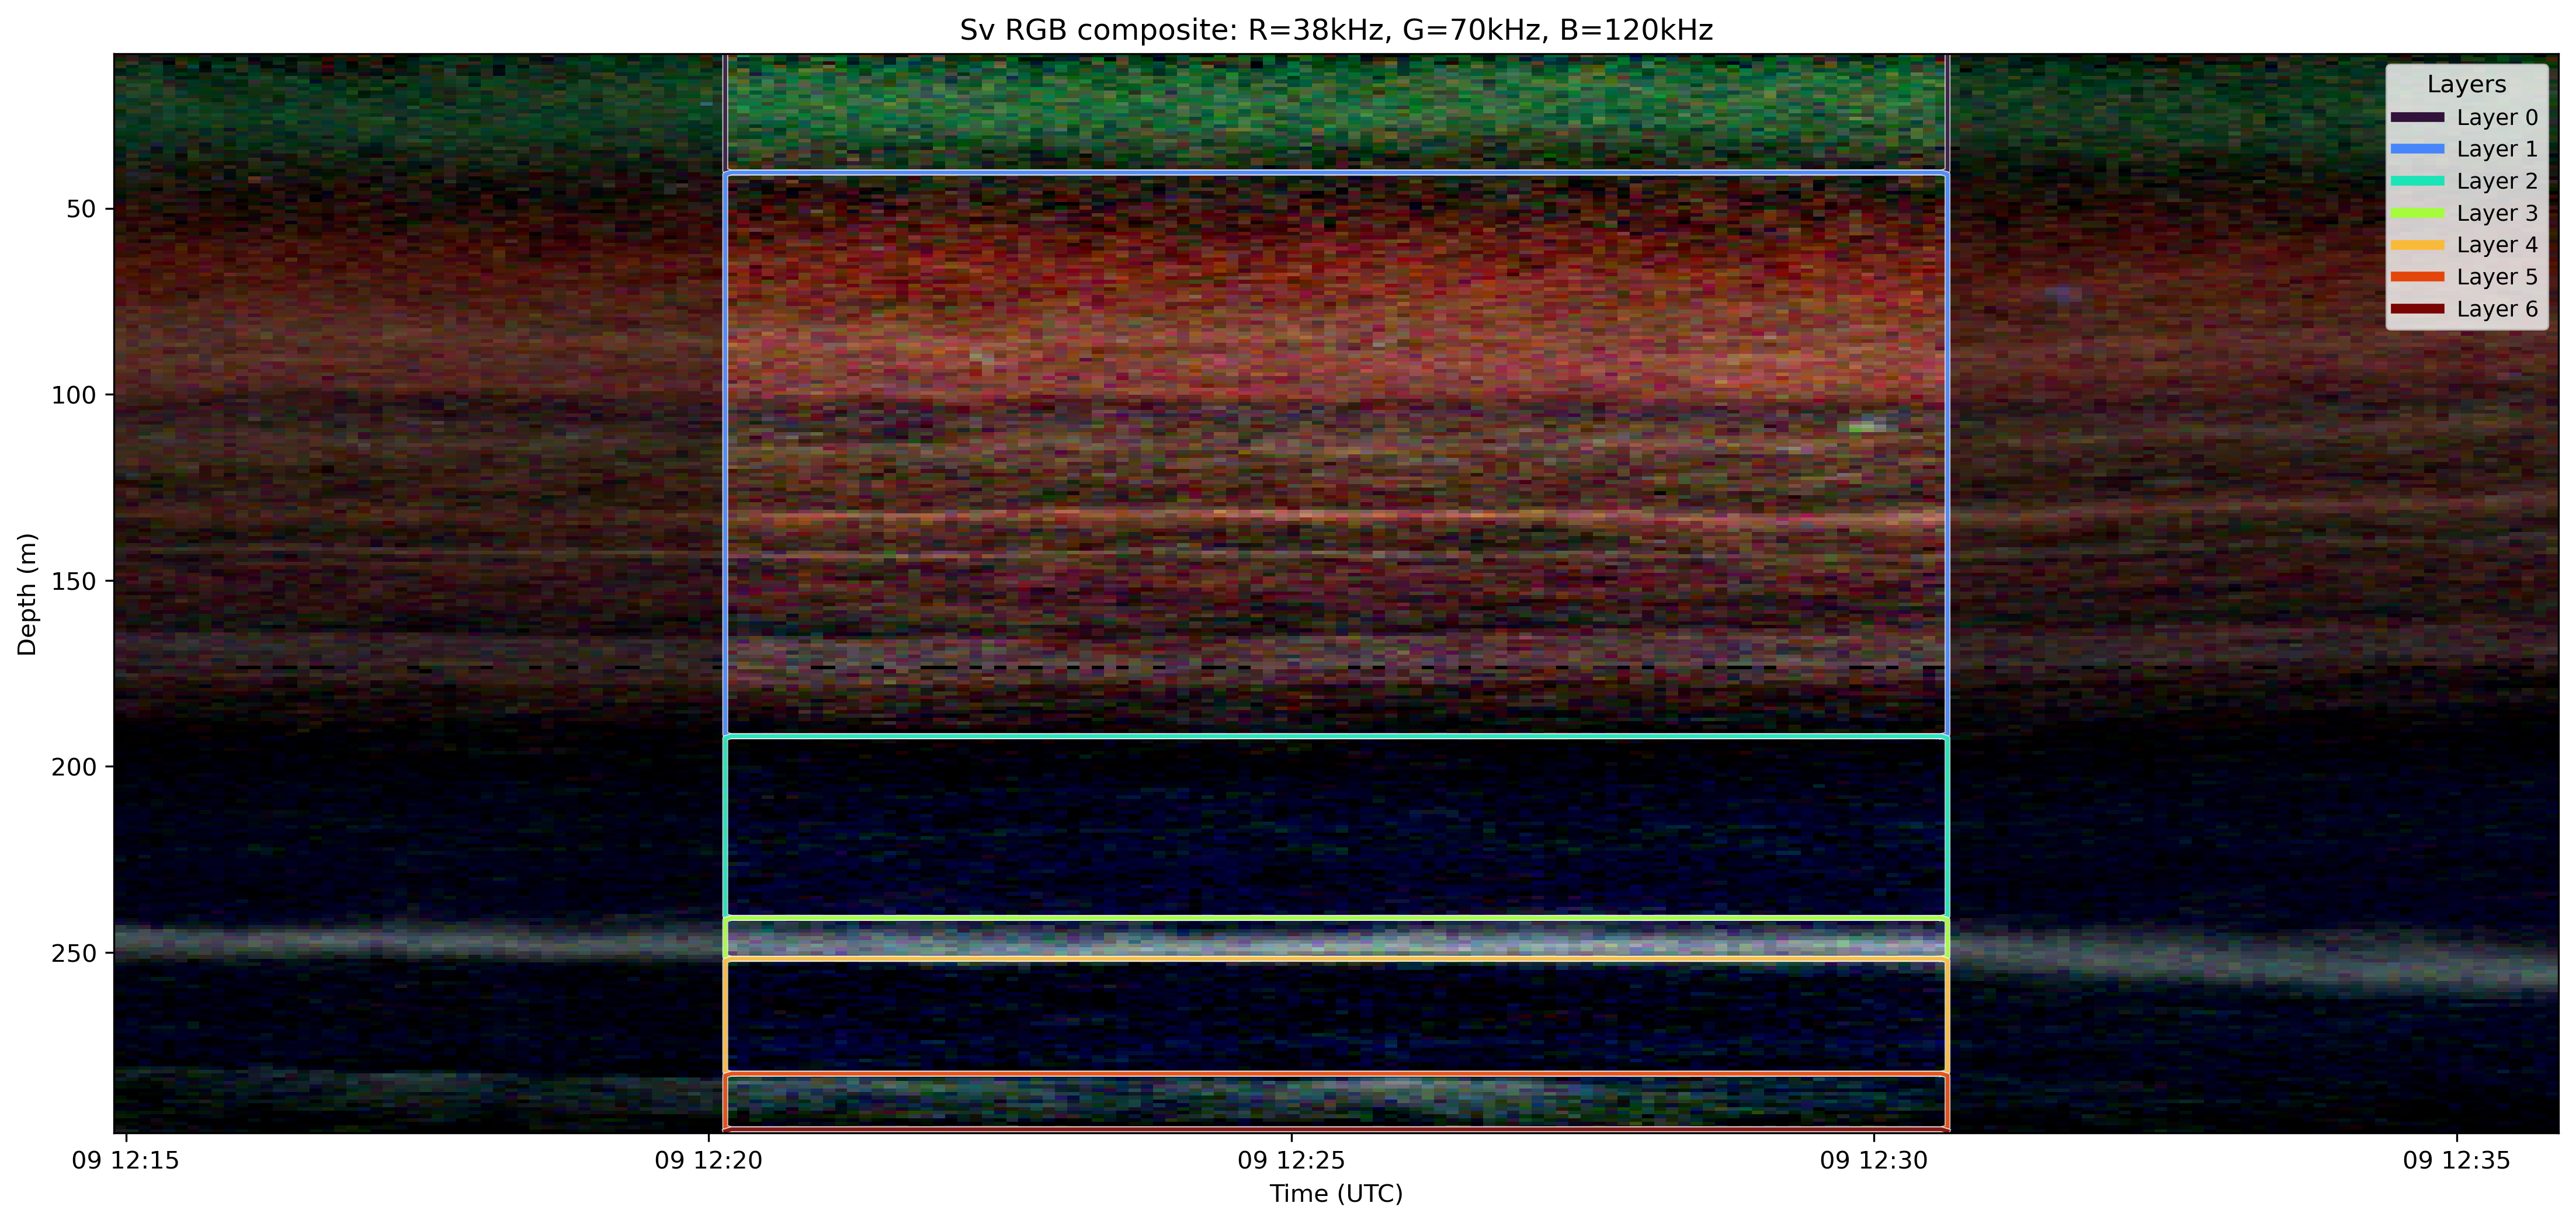

In [ ]:
# Plot rgb echogram with layers
outpath = Path("./output/figures/")
time_slice = slice(start_index-50, end_index+50)

i_zmax = np.argmin(np.abs(depth.values - 300))
depth_slice = slice(0, i_zmax)

print(f"\nPlotting echograms for time slice ({time_slice.start}-{time_slice.stop}) and depth slice () to folder:\n{outpath}")
print()

plot_sv_rgb(
    sv,
    outpath=outpath,
    ei=EI,
    vmin=-80,
    vmax=-50,
    time_slice=time_slice,
    depth_slice=depth_slice,
    rgb_freqs=[38, 70, 120],
    class_var="layer",
    mask_alpha=0.,
)

Image.open('output/figures/amazomix_3pings1m_Sv_echogram_RGB_38_70_120kHz_T348934-349134_Z0-291_clip-80--50dB_layer.png')

/Users/gaspardringuenet/Projects/acoustic-communities/env/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/gaspardringuenet/Projects/acoustic-communities/env/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/gaspardringuenet/Projects/acoustic-communities/env/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/gaspardringuenet/Projects/acoustic-communities/env/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/gaspardringuenet/Projects/acoustic-communities/env/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/User

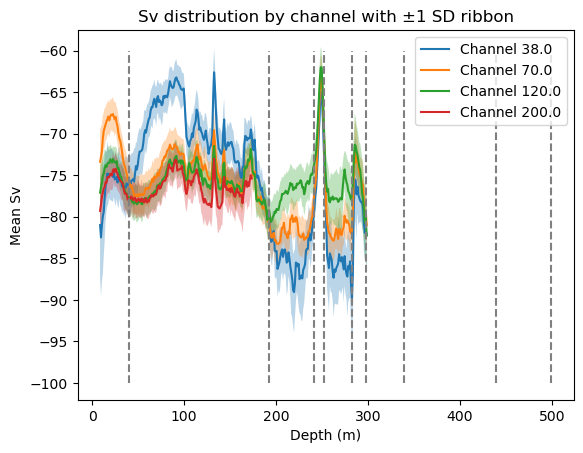

In [ ]:
sv = sv.isel(time=slice(start_index, end_index), depth=slice(0, i_zmax))

# Compute mean and std of Sv across time
mean_sv = sv.mean(dim="time", skipna=True)
std_sv = sv.std(dim="time", skipna=True, )

# Plot each channel with ribbon
fig, ax = plt.subplots()

for channel in mean_sv.channel:
    depth = mean_sv["depth"]
    mean_vals = mean_sv.sel(channel=channel)
    std_vals = std_sv.sel(channel=channel)

    ax.plot(depth, mean_vals, label=f"Channel {channel.values}")
    ax.fill_between(
        depth,
        mean_vals - std_vals,
        mean_vals + std_vals,
        alpha=0.3
    )

ax.vlines(borders, ymin=-100, ymax=-60, linestyle='--', colors="grey")

ax.set_xlabel("Depth (m)")
ax.set_ylabel("Mean Sv")
ax.legend()
ax.set_title("Sv distribution by channel with ±1 SD ribbon")
plt.show();

In [11]:
STOP

NameError: name 'STOP' is not defined

In [24]:
import numpy as np
import xarray as xr

# Build full borders (include min and max of depth)
depth = sv["depth"]
time = sv["time"]
borders_full = np.concatenate([[depth.min().item()], borders, [depth.max().item()]])

# Digitize depths into layer indices
layer_idx = np.digitize(depth, borders_full) - 1  # subtract 1 for 0-based layer indices
layer_idx = np.stack([layer_idx for i in range(frame)], axis=0) # assign layer to each pixel and not 

# 3Make a new DataArray for the layer index (aligned with depth)
layer_idx_da = xr.DataArray(
    layer_idx,
    coords={"time": sv.time, "depth": sv.depth},
    dims=["time", "depth"],
    name="layer"
)

# Assign as coordinate
sv = sv.assign_coords(layer=layer_idx_da)

In [20]:
import pandas as pd

FIGSIZE = (6, 5)
REF_FREQ = 38.
N_SAMPLES = 100_000

# Get valid Sv values as xarray.DataArray and print maximum valid depth per channel
valid = ~np.isnan(sv)
valid_any = valid.any(dim=[d for d in sv.dims if d not in ("depth", "channel")])
valid_depths = sv["depth"].where(valid_any)
max_valid_depth = valid_depths.max(dim="depth", skipna=True)

# 2D hexbin plot in the 0 - 300 m depth range
max_freq = 120.
max_depth = float(max_valid_depth.sel(channel=max_freq))

sv = filter_depth(sv, max_depth)
ch_list = get_ch_list(sv, max_freq, ch_ref=REF_FREQ)
sv_diffs = compute_differences(sv, ch_ref=REF_FREQ, ch_list=ch_list)

sv_diffs_and_layer = sv_diffs.copy()
sv_diffs_and_layer["layer"] = sv["layer"]

flats = flatten_valid(*sv_diffs_and_layer.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

df = pd.DataFrame.from_dict(dict(zip(sv_diffs_and_layer.keys(), samples)))

n_samples (100000) > array length (29058), keeping all elements...


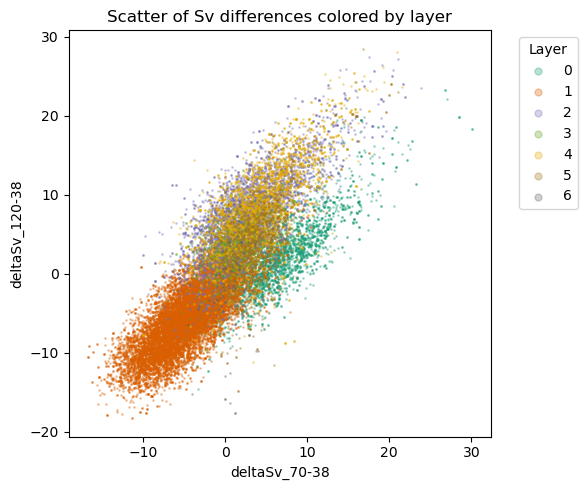

In [21]:
df["layer"] = df["layer"].astype("category")

# Generate colors for each layer
layers = df["layer"].cat.categories
colors = plt.get_cmap("Dark2")(np.linspace(0, 1, len(layers)))
color_dict = dict(zip(layers, colors))

plt.figure(figsize=FIGSIZE)

for layer in layers:
    mask = df["layer"] == layer
    plt.scatter(
        df.loc[mask, "deltaSv_70-38"],
        df.loc[mask, "deltaSv_120-38"],
        s=1,
        alpha=0.3,
        color=color_dict[layer],
        label=str(layer)
    )

plt.xlabel("deltaSv_70-38")
plt.ylabel("deltaSv_120-38")
plt.title("Scatter of Sv differences colored by layer")
plt.legend(title="Layer", markerscale=5, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'layer' is categorical
df["layer"] = df["layer"].astype("category")

# Create FacetGrid: one scatter plot per layer
g = sns.FacetGrid(df, col="layer", col_wrap=4, height=4, sharex=True, sharey=True)
#g.map_dataframe(sns.scatterplot, x="deltaSv_70-38", y="deltaSv_120-38", s=5, alpha=0.5)
g.map_dataframe(sns.histplot, x="deltaSv_70-38", y="deltaSv_120-38", bin)
#g.map_dataframe(sns.kdeplot, x="deltaSv_70-38", y="deltaSv_120-38", fill=True)

# Adjust titles and layout
g.set_axis_labels("deltaSv_70-38", "deltaSv_120-38")
g.set_titles(col_template="Layer {col_name}")
plt.tight_layout()
plt.show()

SyntaxError: positional argument follows keyword argument (2556596980.py, line 10)

In [ ]:
import numpy as np
import pandas as pd

layer_groups = df.groupby("layer")

gaussians = {}
for layer, group in layer_groups:
    X = group[["deltaSv_70-38", "deltaSv_120-38"]].values
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)
    gaussians[layer] = {"mean": mu, "cov": cov}

/var/folders/mr/p37q64sn0fj06kw8cghzs3v40000gn/T/ipykernel_90542/2056365332.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  layer_groups = df.groupby("layer")


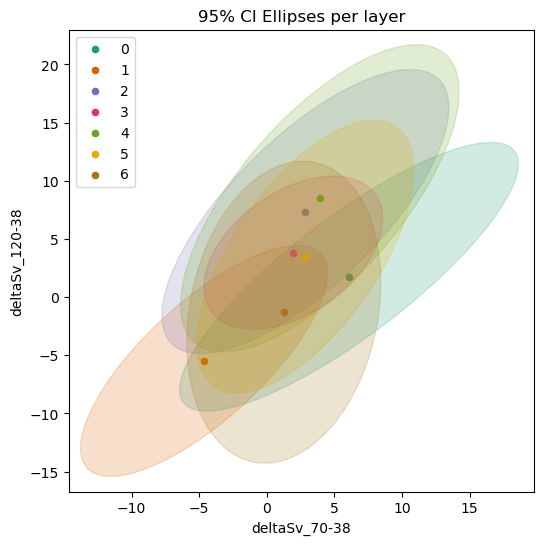

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def plot_gaussian_ellipse(ax, mean, cov, color='r', alpha=0.3, n_std=5.991):
    """
    Plot a 2D Gaussian ellipse for 95% CI.
    n_std = chi2.ppf(0.95, df=2) ~ 5.991
    """
    # Eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    # Width and height
    width, height = 2 * np.sqrt(vals * n_std)
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor=color, alpha=alpha)
    ax.add_patch(ellipse)

# Plot
fig, ax = plt.subplots(figsize=(6,6))

colors = plt.get_cmap("Dark2").colors
for i, (layer, params) in enumerate(gaussians.items()):
    mu, cov = params["mean"], params["cov"]
    plot_gaussian_ellipse(ax, mu, cov, color=colors[i % len(colors)], alpha=0.2)
    ax.scatter(*mu, color=colors[i % len(colors)], label=str(layer), s=20)

ax.set_xlabel("deltaSv_70-38")
ax.set_ylabel("deltaSv_120-38")
ax.set_title("95% CI Ellipses per layer")
ax.legend()
plt.show()


In [ ]:
def bhattacharyya_distance(mu1, cov1, mu2, cov2):
    cov_mean = 0.5 * (cov1 + cov2)
    diff = mu2 - mu1
    term1 = 0.125 * diff.T @ np.linalg.inv(cov_mean) @ diff
    term2 = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1)*np.linalg.det(cov2)))
    return term1 + term2

# Compute pairwise distances
layers = list(gaussians.keys())
for i in range(len(layers)):
    for j in range(i+1, len(layers)):
        g1, g2 = gaussians[layers[i]], gaussians[layers[j]]
        d = bhattacharyya_distance(g1["mean"], g1["cov"], g2["mean"], g2["cov"])
        print(f"Bhattacharyya distance between layer {layers[i]} and {layers[j]}: {d:.3f}")


Bhattacharyya distance between layer 0 and 1: 0.771
Bhattacharyya distance between layer 0 and 2: 1.010
Bhattacharyya distance between layer 0 and 3: 0.719
Bhattacharyya distance between layer 0 and 4: 0.911
Bhattacharyya distance between layer 0 and 5: 0.389
Bhattacharyya distance between layer 0 and 6: 0.374
Bhattacharyya distance between layer 1 and 2: 1.034
Bhattacharyya distance between layer 1 and 3: 0.979
Bhattacharyya distance between layer 1 and 4: 1.111
Bhattacharyya distance between layer 1 and 5: 0.674
Bhattacharyya distance between layer 1 and 6: 0.525
Bhattacharyya distance between layer 2 and 3: 0.229
Bhattacharyya distance between layer 2 and 4: 0.013
Bhattacharyya distance between layer 2 and 5: 0.171
Bhattacharyya distance between layer 2 and 6: 0.479
Bhattacharyya distance between layer 3 and 4: 0.281
Bhattacharyya distance between layer 3 and 5: 0.102
Bhattacharyya distance between layer 3 and 6: 0.322
Bhattacharyya distance between layer 4 and 5: 0.168
Bhattacharyy

In [ ]:
values_dict = dict()
values_dict["layer"] = sv["layer"]
for ch in sv.channel.values:
    values_dict[f"Sv{int(ch)}"] = sv.sel(channel=ch)

flats = flatten_valid(*values_dict.values(), keep_nan=True)
samples = sample_safe(*flats, n_samples=N_SAMPLES)

df = pd.DataFrame.from_dict(dict(zip(values_dict.keys(), samples)))

df["Delta_200"] = df["Sv200"] - df["Sv38"]
df["Delta_120"] = df["Sv120"] - df["Sv38"]
df["Delta_70"] = df["Sv70"] - df["Sv38"]
df["Delta_38"] = 0.

n_samples (100000) > array length (14600), keeping all elements...


In [ ]:
df.head()

,layer,Sv38,Sv70,Sv120,Sv200,Delta_200,Delta_120,Delta_70,Delta_38
0,0,-75.994629,-64.201973,-76.010612,-73.701851,2.292778,-0.015984,11.792656,0.0
1,3,-78.890755,-78.675453,-77.086266,NaN,NaN,1.804489,0.215302,0.0
2,2,-85.411484,-82.553627,-72.345573,NaN,NaN,13.065910,2.857857,0.0
3,4,-87.769440,-83.653122,-75.554733,NaN,NaN,12.214706,4.116318,0.0
4,0,-74.885246,-72.061348,-71.950836,-74.013840,0.871407,2.934410,2.823898,0.0


In [ ]:
df_long = df.melt(
    id_vars=["layer"],
    value_vars=["Delta_38", "Delta_70", "Delta_120", "Delta_200"],
    var_name="frequency",
    value_name="Delta_Sv_38",
    ignore_index=False
).sort_index()

df_long["frequency"] = df_long["frequency"].str.replace("Delta_", "").astype(int)

df_long = df_long.reset_index().rename(columns={"index":"esu"})

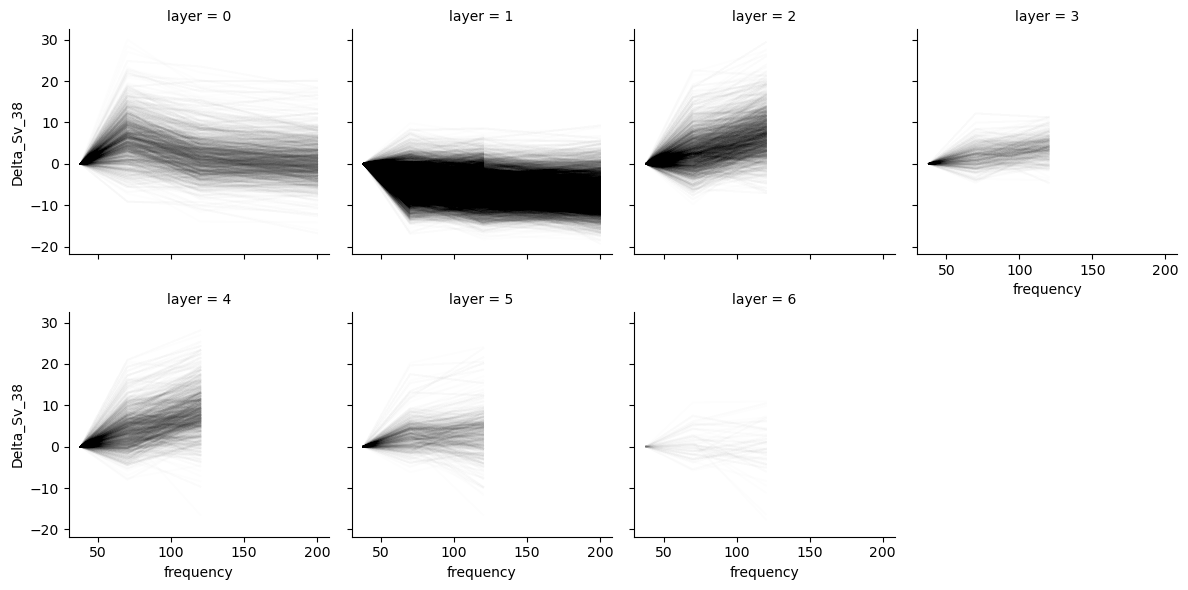

In [ ]:
g = sns.FacetGrid(
    df_long,
    col="layer",
    col_wrap=4,
    sharex=True,
    sharey=True
)
g.map_dataframe(sns.lineplot, x="frequency", y="Delta_Sv_38", units="esu", estimator=None, color="black", alpha=0.008);

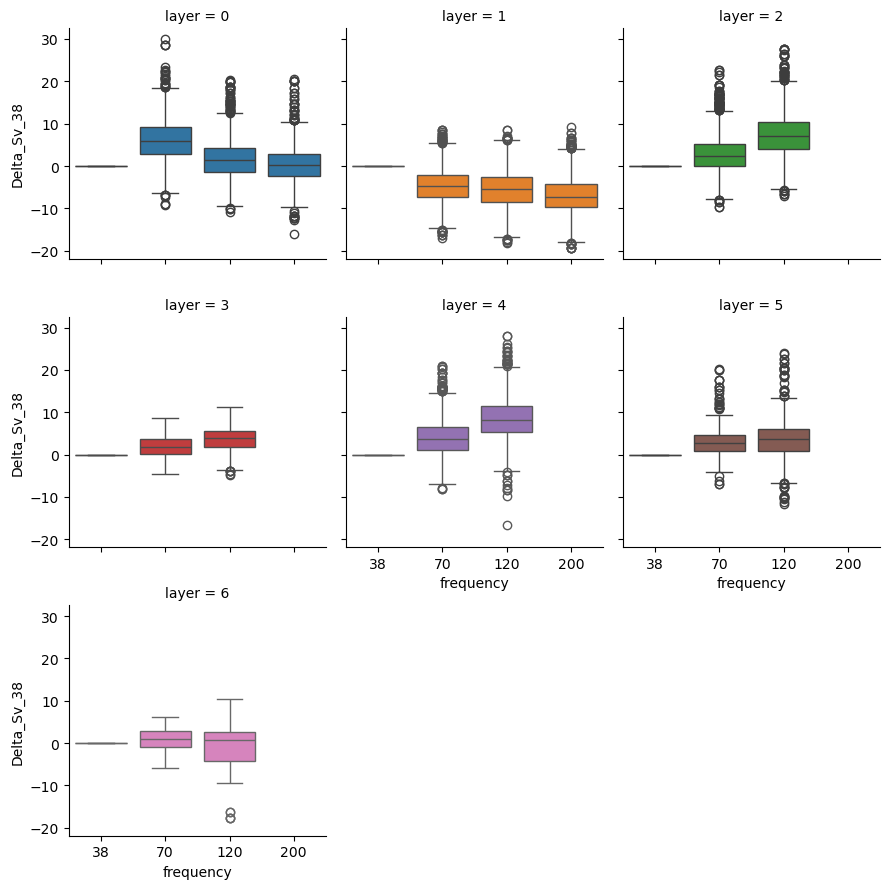

In [ ]:
g = sns.FacetGrid(
    df_long,
    col="layer",
    hue="layer",
    col_wrap=3,
    sharex=True,
    sharey=True
)
g.map_dataframe(sns.boxplot, x="frequency", y="Delta_Sv_38");

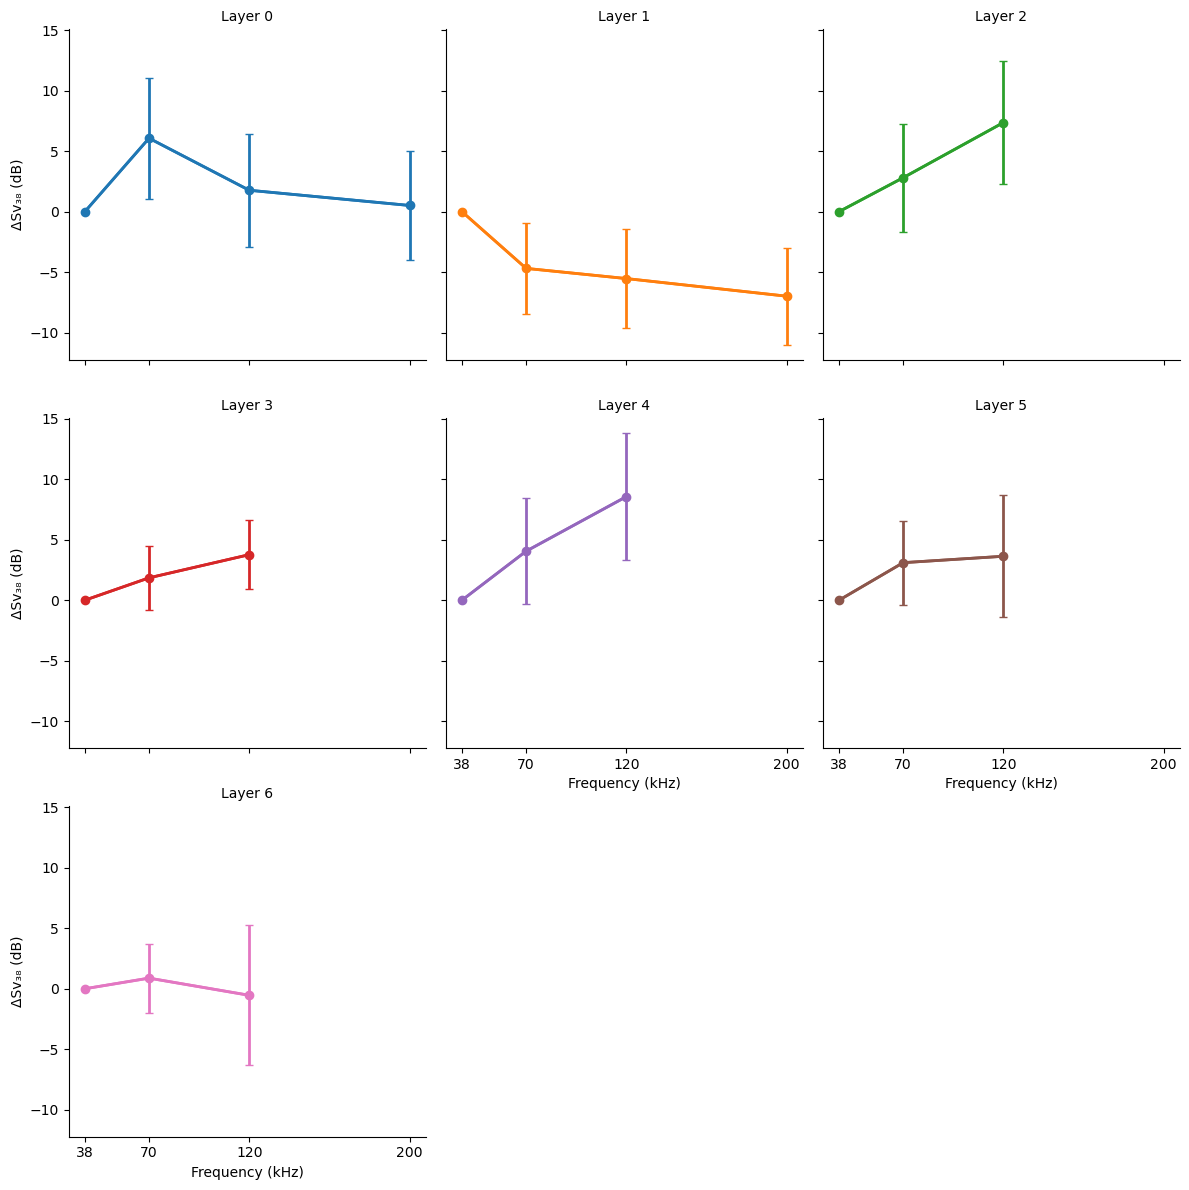

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Ensure frequency is numeric for scaling ---
df_long["frequency"] = (
    df_long["frequency"]
    .astype(str)
    .str.replace("Sv", "", regex=False)
    .astype(float)
)

# --- Compute mean and std per layer × frequency ---
summary = (
    df_long.groupby(["layer", "frequency"])["Delta_Sv_38"]
    .agg(["mean", "std"])
    .reset_index()
)

# --- Create FacetGrid ---
g = sns.FacetGrid(
    df_long,
    col="layer",
    col_wrap=3,
    sharex=True,
    sharey=True,
    height=4
)

# --- Overlay mean ± SD lines ---
colors = sns.color_palette("tab10", n_colors=len(summary["layer"].unique()))
for i, (layer, color) in enumerate(zip(summary["layer"].unique(), colors)):
    data = summary.query("layer == @layer")
    ax = g.axes.flat[i]
    ax.plot(data["frequency"], data["mean"], color=color, lw=2)
    ax.errorbar(
        data["frequency"],
        data["mean"],
        yerr=data["std"],
        color=color,
        lw=2,
        marker="o",
        capsize=3,
    )

# --- Customize axes ---
for ax in g.axes.flat:
    ax.set_xticks(sorted(df_long["frequency"].unique()))
    ax.set_xlabel("Frequency (kHz)")
g.set_axis_labels("Frequency (kHz)", "ΔSv₃₈ (dB)")
g.set_titles(col_template="Layer {col_name}")
plt.tight_layout()
plt.show()
